学号：1120201241 姓名：赵羽菲  数据挖掘互评作业二: 频繁模式与关联规则挖掘
仓库地址：https://github.com/sususutang/DM_HW2

本次实验选择SNAP中的引用网络Cit_HepTh数据集和DBLP数据集进行频繁模式和关联规则挖掘。
数据分析要求：
（1）数据获取与预处理；
（2）频繁模式挖掘：可以是项集、序列和图。
（3）模式命名：如论文-作者网络中合作模式、引用模式和发表模式等，不同的领域的频繁模式的含义也不尽相同，需自行确定模式的名称。
（4）对挖掘结果进行分析；
（5）可视化展示。

本报告是DBLP数据集的挖掘过程报告，频繁模式为论文-作者合作模式，旨在挖掘经常一起合作的一组作者。

In [4]:
import sys
from xml.sax import handler, make_parser
import pickle
import os
import csv

DBLP_XML_PATH = "./dblp.xml"
#此处需要完整添加所有“块”结构的标签，或者需要处理的类型的标签
paperTag = ('article','inproceedings','proceedings','book',
        'incollection','phdthesis','mastersthesis','www')

In [ ]:
# 这一部分是对数据集的预处理，对xml格式文件的处理：
# 注意！这一段代码作为单独的python(dblp_preprocess.py)运行，这里只放置代码。
class CoauthorHandler(handler.ContentHandler):
    def __init__(self):
        self.title = ''
        self.year = ''
        self.author = " "
        self.count = 0
        self.count2 = 0
        self.isPaperTag = 0
        self.isTitleTag = 0
        self.isYearTag = 0
        self.isAuthorTag = 0
        self.authors = []#存储每个“块”中的所有author
        self.storage = {}#用来存储生成的数据，结构为{'title':[year, [author1, author2, ...]]}
    def startDocument(self):
        print('Document Start')
        

    def endDocument(self):
        print('Document End')

    def startElement(self, name, attrs):
        if name in paperTag:
            self.isPaperTag = 1
        if name == 'title':
            self.isTitleTag = 1
        if name == 'author':
            self.isAuthorTag = 1
        if name == 'year':
            self.isYearTag = 1

    def endElement(self, name):
        if name == 'author':
            self.authors.append(str(self.author))  
            self.author = " "
            self.count2 += 1 # 标记作者人数超过两人的论文数
        if name == 'year' or name == 'title':
            pass
        if name in paperTag:
            if self.count2>1:#删除单个作者的文献，因为本实验挖掘作者之间的合作关联
                self.storage[self.title] = []
                self.storage[self.title].append(self.year)
                self.storage[self.title].append(self.authors)
                #print(self.authors)
                self.count += 1
                self.year = ''
                self.authors = []
                self.count2 = 0
                if self.count % 1000 == 0: #每1000轮输出一次提示信息
                    print(self.count)
                    if self.count % 100000 == 0: #由于该数据集太大，这里只选择前100000条数据进行处理
                        print('已保存')
                        saveToCsv(self.storage,"./dblp1.csv")                 
                        exit(0)

            else: # 开始记录下一篇论文的信息
                self.count += 1
                self.year = ''
                self.authors = []
                self.count2 = 0
        

    def characters(self, content):
        if self.isTitleTag == 1:
            self.isTitleTag = 0
            self.title = content
        if self.isAuthorTag == 1:
            self.isAuthorTag = 0
            self.author = content
        if self.isYearTag == 1:
            self.isYearTag = 0
            self.year = content
        
def parserDblpXml():
    
    handler = CoauthorHandler()
    parser = make_parser()
    parser.setContentHandler(handler)
    f = open("./dblp.xml",'r') # 数据集路径
    parser.parse(f)
    f.close()
    return handler.storage


def saveToCsv(storage, file_path): # 保存在csv
    items = storage.items()
    with open(file_path,'w',newline='',encoding='utf-8') as csvfile:#a
        writer = csv.writer(csvfile)
        for item in items:
            tmp_li = []
            tmp_li.append(item[0])
            tmp_li.append(item[1][0])
            tmp_li.append(item[1][1])
            writer.writerow(tmp_li) 
        csvfile.close()
            

if __name__ == '__main__':
    storage = parserDblpXml()

In [40]:
import pandas as pd
from collections import Counter
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Step 1: 数据准备
# 读取DBLP数据集
dblp_data = pd.read_csv('dblp1.csv',header=None,nrows=5000,names=['title','year', 'authors'])  # DBLP数据存储在名为dblp1.csv的文件中，加载5000行


# Step 2: 数据预处理
transactions = [] # 存储全部事务
for item in dblp_data['authors']:
    transaction = [] # 存储单篇论文的全部作者
    authors = str(item).split(',')
    for author in authors:
        start = author.find('\'')
        end = author.find('\'', start+1)
        t_author = author[start+1:end]
        transaction.append(t_author)
        #print(transaction)
    transactions.append(transaction)

In [42]:
# 分析最常出现的作者

counter = Counter()
# 统计每个子列表中出现的值
for sublist in transactions:
    counter.update(sublist)

# 获取出现频率最高的前十个值及其出现次数
most_common_values = counter.most_common(10)

# 打印结果
for value, count in most_common_values:
    print(f"Author: {value}，出现次数: {count}")

Author: J，出现次数: 51
Author: Christoph Meinel，出现次数: 51
Author: Jos，出现次数: 44
Author: Christodoulos A. Floudas，出现次数: 31
Author: Andr，出现次数: 24
Author: Jo，出现次数: 20
Author: Peter Gritzmann，出现次数: 18
Author: Christoph Beierle，出现次数: 17
Author: Fran，出现次数: 16
Author: Rainer Tichatschke，出现次数: 15


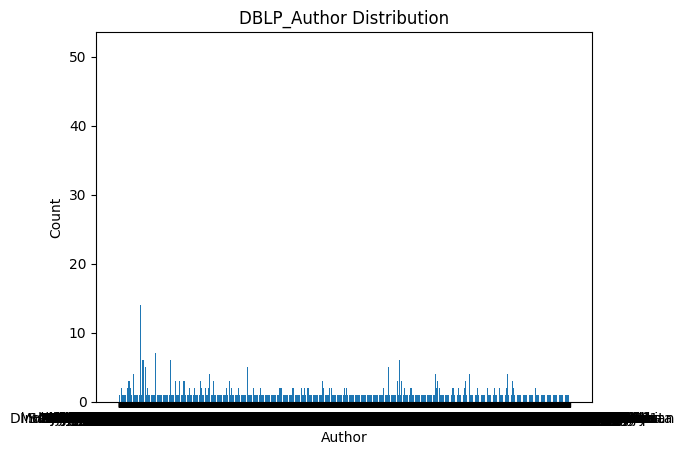

In [43]:
values = counter.keys()
counts = counter.values()

# 绘制柱状图
plt.bar(values, counts)

# 添加标题和轴标签
plt.title('DBLP_Author Distribution')
plt.xlabel('Author')
plt.ylabel('Count')

# 显示图形，数据过多，可视化效果不明显
plt.show()

                 0
count  9845.000000
mean      1.372575
std       1.393205
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max      51.000000


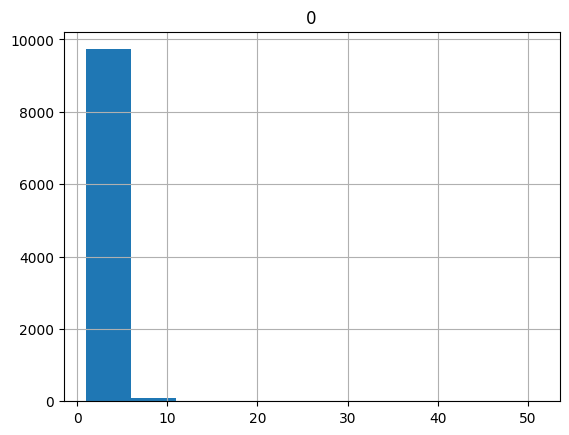

In [44]:
counts_df = pd.DataFrame(counts)
summary = counts_df.describe()

# 打印统计摘要信息
print(summary)
hist = counts_df.hist()

In [45]:
# 将数据的格式转化为布尔矩阵形式，便于关联规则挖掘
te = TransactionEncoder()
encoded_data = te.fit_transform(transactions)
df = pd.DataFrame(encoded_data, columns=te.columns_)

In [46]:
# 计算引用模式的频繁项集
Cit_frequent_itemsets = apriori(df, min_support=0.002, use_colnames=True) # 由于数据集过大，比较分散，这里最低支持度选择较小的数值
print(Cit_frequent_itemsets)

    support                                itemsets
0    0.0020                      (Albert Y. Zomaya)
1    0.0026                      (Alexander Kaplan)
2    0.0028                        (Alfred Menezes)
3    0.0048                                  (Andr)
4    0.0026                         (Anna Slobodov)
5    0.0024                           (Borko Furht)
6    0.0062              (Christodoulos A. Floudas)
7    0.0034                     (Christoph Beierle)
8    0.0102                      (Christoph Meinel)
9    0.0024               (Constantine Stephanidis)
10   0.0028                      (Darrel Hankerson)
11   0.0020           (Efstratios N. Pistikopoulos)
12   0.0032                                  (Fran)
13   0.0030                                     (G)
14   0.0024                           (Harald Sack)
15   0.0026                          (Helmut Seidl)
16   0.0020                             (Henry Lin)
17   0.0102                                     (J)
18   0.0022 

In [47]:
# 计算关联规则
Cit_rules = association_rules(Cit_frequent_itemsets, metric="confidence", min_threshold=0.8)
print(Cit_rules.head())

            antecedents           consequents  antecedent support  \
0    (Alexander Kaplan)  (Rainer Tichatschke)              0.0026   
1  (Rainer Tichatschke)    (Alexander Kaplan)              0.0030   
2    (Darrel Hankerson)      (Alfred Menezes)              0.0028   
3      (Alfred Menezes)    (Darrel Hankerson)              0.0028   
4       (Anna Slobodov)    (Christoph Meinel)              0.0026   

   consequent support  support  confidence        lift  leverage  conviction  \
0              0.0030   0.0026    1.000000  333.333333  0.002592         inf   
1              0.0026   0.0026    0.866667  333.333333  0.002592      7.4805   
2              0.0028   0.0028    1.000000  357.142857  0.002792         inf   
3              0.0028   0.0028    1.000000  357.142857  0.002792         inf   
4              0.0102   0.0026    1.000000   98.039216  0.002573         inf   

   zhangs_metric  
0       0.999599  
1       1.000000  
2       1.000000  
3       1.000000  
4       0

In [48]:
# 打印关联规则的支持度、置信度、提升度和确信度
Cit_rules = Cit_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift','conviction']]
print(Cit_rules)

            antecedents           consequents  support  confidence  \
0    (Alexander Kaplan)  (Rainer Tichatschke)   0.0026    1.000000   
1  (Rainer Tichatschke)    (Alexander Kaplan)   0.0026    0.866667   
2    (Darrel Hankerson)      (Alfred Menezes)   0.0028    1.000000   
3      (Alfred Menezes)    (Darrel Hankerson)   0.0028    1.000000   
4       (Anna Slobodov)    (Christoph Meinel)   0.0026    1.000000   
5         (Harald Sack)    (Christoph Meinel)   0.0022    0.916667   
6           (Henry Lin)         (Xiaobo Zhou)   0.0020    1.000000   
7         (Xiaobo Zhou)           (Henry Lin)   0.0020    1.000000   
8         (Victor Klee)     (Peter Gritzmann)   0.0022    1.000000   

         lift  conviction  
0  333.333333         inf  
1  333.333333      7.4805  
2  357.142857         inf  
3  357.142857         inf  
4   98.039216         inf  
5   89.869281     11.8776  
6  500.000000         inf  
7  500.000000         inf  
8  277.777778         inf  


挖掘结果分析：
针对以上实验结果，我们可以得到如下强相关规则：
1. (Alexander Kaplan) -> (Rainer Tichatschke)
2. (Darrel Hankerson) -> (Alfred Menezes)
3. (Anna Slobodov) -> (Christoph Meinel)
4. (Harald Sack) -> (Christoph Meinel)
5. (Henry Lin) -> (Xiaobo Zhou) 等

这些规则中，所有的置信度都是1.0，表示关联非常强，而且提升度也都是显著大于1，因此，这些规则可以被认为是强关联规则。

因此，我们可以得出结果：Alexander Kaplan与Rainer Tichatschke经常合作；Darrel Hankerson与Alfred Menezes经常合作；Henry Lin与Xiaobo Zhou经常合作等。

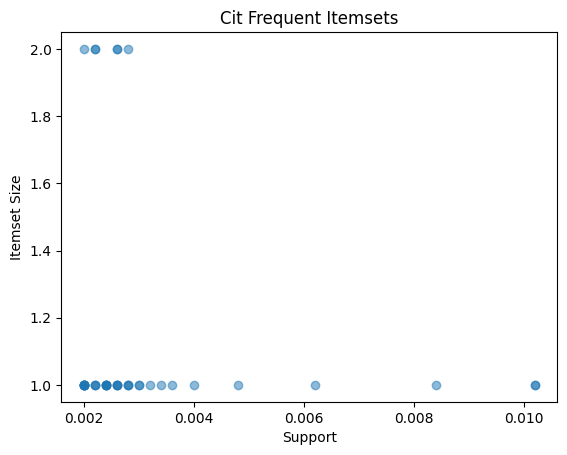

In [49]:
# 频繁项集的支持度和项集大小的关系图
plt.scatter(Cit_frequent_itemsets['support'], Cit_frequent_itemsets['itemsets'].apply(len), alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Itemset Size')
plt.title('Cit Frequent Itemsets')
plt.show()

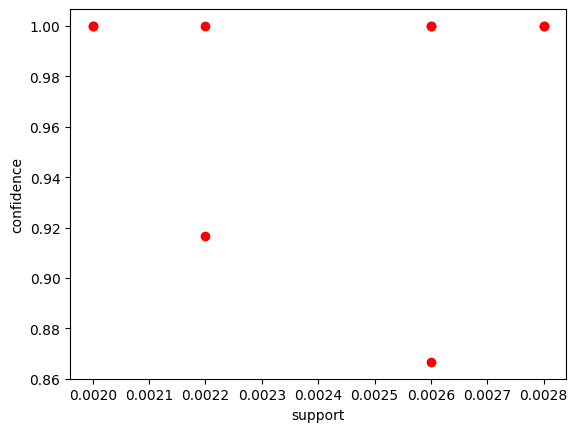

In [50]:
# 支持度与置信度关联关系展示
plt.xlabel('support')
plt.ylabel('confidence')
for i in range(Cit_rules.shape[0]):
    plt.scatter(Cit_rules.support[i],Cit_rules.confidence[i],c='r')

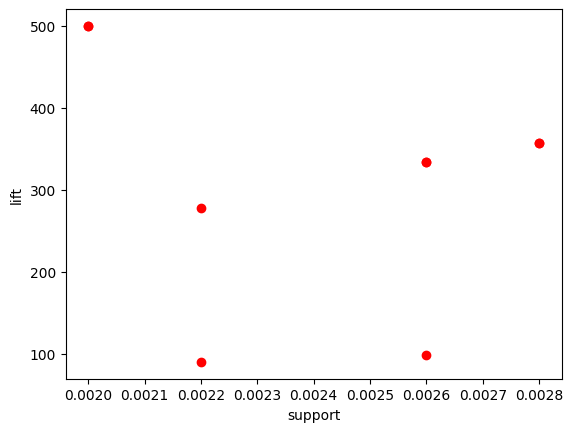

In [51]:
# 支持度与lift关联关系展示
plt.xlabel('support')
plt.ylabel('lift')
for i in range(Cit_rules.shape[0]):
    plt.scatter(Cit_rules.support[i],Cit_rules.lift[i],c='r')